#### Day 1

In [1]:
import math
import itertools
import re

import numpy as np
import pandas as pd
import networkx as nx

from random import randint
from collections import Counter, defaultdict
from copy import deepcopy

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
class IntCode_v3:
    def __init__(self, intcode):
        self.intcode = intcode
        self.reset()
    
    def reset(self):
#         self.work_intcode = self.intcode[:]
        self.work_intcode = {idx:val for idx, val in enumerate(self.intcode)} 
        self.output = []
        self.mem = {}
        
    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as file:
            return cls([int(x) for x in file.read().split(',')])
    
    @classmethod
    def test_txt(cls, text, calc, **input_dict):
        test_intcode = cls([int(x) for x in text.split(',')])
        test_intcode.intcodeRead(calc, outmode = 0, **input_dict)
    
    def mode_manage(self, num, mode):
        if mode == 0:
            return self.work_intcode.get(num, 0)
        elif mode == 1:
            return num
        elif mode == 2:
            return self.work_intcode.get(self.mem['relbase'] + num, 0)
    
    def spec_mode_manage(self, num, mode):
        if mode == 0 or mode == 1:
            return num
        elif mode == 2:
            return self.mem['relbase'] + num
                
    def instr_manage(self, selfmem):      
        current_idx =  selfmem['current_idx']
        
        instr_str = str(self.work_intcode.get(current_idx, 0))
        params = {x:int(y) for x, y in enumerate(reversed(instr_str[:len(instr_str)-2]))}
        opcode = instr_str[len(instr_str)-2:]
        
        
#         print(instr_str, opcode)
        if int(opcode) == 1:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            self.work_intcode[output_loc] = param_a + param_b
            
            current_idx += 4
            
        elif int(opcode) == 2:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            self.work_intcode[output_loc] = param_a * param_b
            
            current_idx += 4

        elif int(opcode) == 3: 
            try:
                move_num = self.spec_mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))            
                self.work_intcode[move_num] = selfmem['inputs'][selfmem['input_idx']]
                selfmem['input_idx'] += 1
            
                current_idx += 2
            except IndexError:
                print('HALT COMMAND')
                selfmem['midhalt'] = 1
        
        elif int(opcode) == 4:
            val_output = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            self.output.append(val_output)
            
            current_idx += 2
        
        elif int(opcode) == 5:
            check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            if check != 0:
                current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 6:
            check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            if check == 0:
                current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 7:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            if param_a < param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
            
            current_idx += 4
        
        elif int(opcode) == 8:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            if param_a == param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
                
            current_idx += 4
        
        elif int(opcode) == 9:
            rel_adj = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            selfmem['relbase'] += rel_adj
                
            current_idx += 2
        
        return current_idx
       
    def intcodeRead(self, calc, outmode = 1, **input_dict):
        current_idx = 0
        
        if self.mem == {}:
            self.mem = input_dict
            self.mem['input_idx'] = 0
            self.mem['midhalt'] = None
            self.mem['current_idx'] = 0
            self.mem['relbase'] = 0
            
            if isinstance(self.mem.get('inputs',0), int):
                self.mem['inputs'] = [self.mem.get('inputs',0)]
        else:
            self.mem['inputs'] = input_dict['inputs']
            self.mem['midhalt'] = 0
#         print(self.output)
             
        if calc == 'nv':
            print(
                f'Calculating using NOUN/VERB method\n' 
                f'Noun: {nv.get("noun", 0)}\n' 
                f'Verb: {nv.get("verb", 0)}\n' 
                f"Note: If noun or verb used in inputs are > 99, noun and verb default to intcode's default values"
            )
            self.work_intcode[1] = self.mem.get('noun', x[1])
            self.work_intcode[2] = self.mem.get('verb', x[2])
            
        elif calc == 'input':
            print(
#                 f'Calculating using input method\n'
#                 f'Note: Default value if "val" variable not in parameters is 0'
            )
        
        while self.work_intcode.get(self.mem['current_idx'], 0) != 99 and self.mem['midhalt'] != 1:
#             print(self.mem['current_idx'])
            self.mem['current_idx'] = self.instr_manage(self.mem)

        reconstituted = [self.work_intcode.get(x, 0) for x in range(max(self.work_intcode)+1)]
        
        if outmode == 1:
            return reconstituted, self.output
        elif outmode == 'output_only':
            return self.output
        elif outmode == 'last_out':
            return self.output[-1]
        else:
            print(reconstituted, self.output, self.mem.get('inputs'))

In [3]:
with open('day01.txt', 'r') as file:
    solution = 0
    for x in file.readlines():
        solution += math.trunc(float(x)/3) -2

solution

3336439

In [4]:
def fuel_calc(num: float) -> float:
    calc = math.trunc(num/3) - 2
    if calc > 0:
        return calc
    else:
        return 0

In [5]:
with open('day01.txt', 'r') as file:
    solution = 0
    for x in file.readlines():
        solution += fuel_calc(float(x))

        add_fuel = fuel_calc(fuel_calc(float(x)))
        solution += add_fuel

        while fuel_calc(add_fuel) > 0: 
            add_fuel = fuel_calc(add_fuel)
            solution += add_fuel

solution

5001791

#### Day 2

In [6]:
with open('day02.txt', 'r') as file:
    intcode = [int(x) for x in file.read().split(',')]
    intcode[1] = 12
    intcode[2] = 2

In [7]:
class IntCode:
    def __init__(self, intcode, noun, verb):
        self.intcode = intcode
        self.noun = noun
        self.verb = verb
    
    @classmethod
    def load_txt(cls, filename):
        with open(filename, 'r') as file:
            return cls(intcode = [int(x) for x in file.read().split(',')], noun = intcode[1], verb = intcode[2])
    
    @staticmethod
    def manual_read(target, test=0):
        x = target[:]
        for num in range(0, len(x), 4):
            current_op = x[num]

            if current_op == 99:
                break
            else:
                input_loc1 = x[num+1]
                input_loc2 = x[num+2]
                output_loc3 = x[num+3]
                if current_op == 1:
                    x[output_loc3] = x[input_loc1] + x[input_loc2]
                elif current_op == 2:
                    x[output_loc3] = x[input_loc1] * x[input_loc2]

            if test == 1:
                break

        return x[0]
    
    def intcodeRead(self, noun=-1, verb=-1, test = 0):
        x = self.intcode[:]
        if noun == -1 or verb == -1:
            print(f'No valid noun/verb pair, using default Noun: {self.noun}, Verb:{self.verb}')
            x[1] = self.noun
            x[2] = self.verb
        else:
            x[1] = noun
            x[2] = verb

        result = self.manual_read(x, test)
        return result

    def brute_force(self, target):
        noun_t = randint(0, 100)
        verb_t = randint(0, 100)
        
        while self.intcodeRead(noun=noun_t, verb=verb_t) != target:
            print(f'Pair noun: {noun_t}, verb: {verb_t}, result = {self.intcodeRead(noun=noun_t, verb=verb_t)}')
            noun_t = randint(0, 100)
            verb_t = randint(0, 100)
            
        print(noun_t, verb_t)

In [8]:
a = IntCode.load_txt('day02.txt')
a.brute_force(19690720)

Pair noun: 91, verb: 56, result = 53098700
Pair noun: 89, verb: 43, result = 51946687
Pair noun: 14, verb: 20, result = 8746664
Pair noun: 47, verb: 2, result = 27754646
Pair noun: 41, verb: 97, result = 24298741
Pair noun: 44, verb: 31, result = 26026675
Pair noun: 0, verb: 67, result = 682711
Pair noun: 4, verb: 97, result = 2986741
Pair noun: 22, verb: 91, result = 13354735
Pair noun: 44, verb: 68, result = 26026712
Pair noun: 65, verb: 84, result = 38122728
Pair noun: 14, verb: 37, result = 8746681
Pair noun: 52, verb: 97, result = 30634741
Pair noun: 12, verb: 82, result = 7594726
Pair noun: 33, verb: 47, result = 19690691
Pair noun: 1, verb: 77, result = 1258721
Pair noun: 13, verb: 1, result = 8170645
Pair noun: 29, verb: 38, result = 17386682
Pair noun: 88, verb: 34, result = 51370678
Pair noun: 15, verb: 82, result = 9322726
Pair noun: 18, verb: 47, result = 11050691
Pair noun: 90, verb: 11, result = 52522655
Pair noun: 47, verb: 67, result = 27754711
Pair noun: 60, verb: 48, 

Pair noun: 81, verb: 32, result = 47338676
Pair noun: 33, verb: 1, result = 19690645
Pair noun: 8, verb: 63, result = 5290707
Pair noun: 12, verb: 63, result = 7594707
Pair noun: 72, verb: 18, result = 42154662
Pair noun: 43, verb: 72, result = 25450716
Pair noun: 37, verb: 24, result = 21994668
Pair noun: 9, verb: 100, result = 5866744
Pair noun: 68, verb: 39, result = 39850683
Pair noun: 37, verb: 21, result = 21994665
Pair noun: 92, verb: 23, result = 53674667
Pair noun: 14, verb: 0, result = 8746644
Pair noun: 81, verb: 81, result = 47338725
Pair noun: 43, verb: 5, result = 25450649
Pair noun: 26, verb: 9, result = 15658653
Pair noun: 99, verb: 96, result = 57706740
Pair noun: 51, verb: 80, result = 30058724
Pair noun: 41, verb: 97, result = 24298741
Pair noun: 11, verb: 46, result = 7018690
Pair noun: 22, verb: 1, result = 13354645
Pair noun: 61, verb: 81, result = 35818725
Pair noun: 71, verb: 74, result = 41578718
Pair noun: 87, verb: 0, result = 50794644
Pair noun: 24, verb: 11

Pair noun: 22, verb: 58, result = 13354702
Pair noun: 16, verb: 79, result = 9898723
Pair noun: 52, verb: 1, result = 30634645
Pair noun: 21, verb: 61, result = 12778705
Pair noun: 97, verb: 71, result = 56554715
Pair noun: 98, verb: 47, result = 57130691
Pair noun: 16, verb: 84, result = 9898728
Pair noun: 61, verb: 98, result = 35818742
Pair noun: 77, verb: 65, result = 45034709
Pair noun: 9, verb: 81, result = 5866725
Pair noun: 0, verb: 36, result = 682680
Pair noun: 99, verb: 41, result = 57706685
Pair noun: 55, verb: 10, result = 32362654
Pair noun: 54, verb: 2, result = 31786646
Pair noun: 43, verb: 32, result = 25450676
Pair noun: 22, verb: 35, result = 13354679
Pair noun: 34, verb: 67, result = 20266711
Pair noun: 70, verb: 75, result = 41002719
Pair noun: 84, verb: 96, result = 49066740
Pair noun: 76, verb: 46, result = 44458690
Pair noun: 38, verb: 79, result = 22570723
Pair noun: 64, verb: 68, result = 37546712
Pair noun: 40, verb: 70, result = 23722714
Pair noun: 67, verb:

#### Day 3

In [9]:
def line_point_cov(string) -> list:
    # ref
    ref = {'R': np.array([1,0]), 'L': np.array([-1,0]), 'U': np.array([0,1]), 'D': np.array([0,-1])}
    
    # clean
    line = [aa.strip() for aa in string.split(',')]
    current_pos = np.array([0,0])    
    
    point_list = [] #from position 1 to end
    endpoints = [current_pos]
    
    for a in line:
        delta = ref[a[0]] * int(a[1:])
        new_pos = current_pos + delta
        
        collect_x = [current_pos[0], new_pos[0]]
        collect_y = [current_pos[1], new_pos[1]]
        
        point_list.extend([(x,y) for x in range(min(collect_x),max(collect_x)+1,1) for y in range(min(collect_y),max(collect_y)+1,1)])
        endpoints.append(new_pos)
        
        current_pos = new_pos
        
    return point_list, endpoints

In [10]:
with open('day03.txt', 'r') as file:
    point_1, end_1 = line_point_cov(file.readline())
    point_2, end_2 = line_point_cov(file.readline())
    line_1 = set(point_1)
    line_2 = set(point_2)

In [11]:
sorted([(x, abs(x[0])+abs(x[1])) for x in line_1.intersection(line_2)], key = lambda x: x[1])

[((0, 0), 0),
 ((-610, 675), 1285),
 ((-517, 777), 1294),
 ((-274, 1105), 1379),
 ((-886, 557), 1443),
 ((-771, 675), 1446),
 ((-274, 1269), 1543),
 ((-999, 557), 1556),
 ((-274, 1286), 1560),
 ((-309, 1411), 1720),
 ((-557, 1201), 1758),
 ((-771, 987), 1758),
 ((-490, 1269), 1759),
 ((-1648, 112), 1760),
 ((-490, 1286), 1776),
 ((-517, 1269), 1786),
 ((-517, 1286), 1803),
 ((-1728, -115), 1843),
 ((-1320, 536), 1856),
 ((-1753, 112), 1865),
 ((-1470, 536), 2006),
 ((-1753, 282), 2035),
 ((-751, 1286), 2037),
 ((-1648, 413), 2061),
 ((-905, 1201), 2106),
 ((-905, 1258), 2163),
 ((-905, 1267), 2172),
 ((-766, 1509), 2275),
 ((-766, 1526), 2292),
 ((-899, 1506), 2405),
 ((-1444, 1051), 2495),
 ((-2674, -53), 2727),
 ((-714, 2037), 2751),
 ((-2674, -237), 2911),
 ((-648, 2290), 2938),
 ((-714, 2290), 3004),
 ((-3076, -53), 3129),
 ((-3110, -53), 3163),
 ((-880, 2290), 3170),
 ((-3429, -97), 3526),
 ((-3429, -198), 3627),
 ((-1944, 1899), 3843),
 ((-3857, -97), 3954),
 ((-3857, -198), 4055

In [12]:
endcop = end_1[1:]
intersections = line_1.intersection(line_2)
intersections.remove((0,0))
new_end1 = [np.array([0, 0])]

for a in endcop:
    for point in intersections:
        align_x = point[0] == new_end1[-1][0]
        align_y = point[1] == new_end1[-1][1]
        
        mod_x = abs(point[0] - new_end1[-1][0])
        mod_y = abs(point[1] - new_end1[-1][1])
        
        if (align_x and mod_y) or (align_y and mod_x):
            new_end1.append(point)
        
    new_end1.append(a)
        

In [13]:
def line_rebuild(endpoints, intersections):
    completed = []

    for a, b in zip(endpoints, endpoints[1:]):
        change_x = abs(a[0] - b[0]) > 0  
        change_y = abs(a[1] - b[1]) > 0  
        intersecting = [a]
        flag_key = None

        for point in intersections:
            align_x = point[0] == a[0]
            align_y = point[1] == a[1]

            if change_x and align_y:
                intersecting.append(np.array(point))
                flag_key = 0
            elif change_y and align_x:
                intersecting.append(np.array(point))
                flag_key = 1

        key_1 = a[flag_key]
        key_2 = b[flag_key]

        if flag_key != None:
            flag_order = True if key_1 > key_2 else False
            intersecting = sorted(intersecting, reverse=flag_order, key = lambda x: x[flag_key])

        completed.extend(intersecting)

    return completed

In [14]:
intersections = line_1.intersection(line_2)
intersections.remove((0,0))

line_rebuild(end_1, intersections)

[array([0, 0]),
 array([995,   0]),
 array([ 995, -933]),
 array([ 711, -933]),
 array([ 711, -353]),
 array([1164, -353]),
 array([1164,    2]),
 array([812,   2]),
 array([812, 365]),
 array([306, 365]),
 array([306, 235]),
 array([606, 235]),
 array([606, 123]),
 array([-145,  123]),
 array([-145,  368]),
 array([ 29, 368]),
 array([  29, 1269]),
 array([-274, 1269]),
 array([-490, 1269]),
 array([-517, 1269]),
 array([-557, 1269]),
 array([-557, 1201]),
 array([-557, 1199]),
 array([-905, 1199]),
 array([-905, 1201]),
 array([-905, 1258]),
 array([-905, 1267]),
 array([-905, 1506]),
 array([-899, 1506]),
 array([-309, 1506]),
 array([-309, 1411]),
 array([-309, 1105]),
 array([-274, 1105]),
 array([   2, 1105]),
 array([  2, 777]),
 array([-517,  777]),
 array([-610,  777]),
 array([-610,  675]),
 array([-610,  563]),
 array([-771,  563]),
 array([-771,  675]),
 array([-771,  987]),
 array([-771, 1051]),
 array([-1444,  1051]),
 array([-1584,  1051]),
 array([-1584,  1349]),
 array

In [15]:
new_line_1 = line_rebuild(end_1, intersections)
new_line_2 = line_rebuild(end_2, intersections)
final_answer3 = {}

for point in intersections:
    up_to_intersect1 = new_line_1[0:[np.array_equal(point,x) for x in new_line_1].index(True) + 1]
    up_to_intersect2 = new_line_2[0:[np.array_equal(point,x) for x in new_line_2].index(True) + 1]
    
    line1_dist = sum([np.sum(abs(a - b)) for a, b in zip(up_to_intersect1, up_to_intersect1[1:])])
    line2_dist = sum([np.sum(abs(a - b)) for a, b in zip(up_to_intersect2, up_to_intersect2[1:])])
    
    final_answer3[point] = line1_dist+line2_dist

In [16]:
final_answer3[min(final_answer3, key=final_answer3.get)]

14228

#### Day 4

In [17]:
## INPUT RANGE FOR PASSWORD 254032-789860
def pass_check(num):
    str_form = str(num)
    flag1 = 0
    flag2 = 1
    
    # never decreases
    for val in range(len(str_form)-1):
        if str_form[val] == str_form[val+1]:
            flag1 = 1
        if int(str_form[val]) > int(str_form[val+1]):
            flag2 = 0
    
    if flag1 == 1 and flag2 == 1:
        return num
    else:
        return None

In [18]:
match_pass = 0
for number in range(254032, 789860+1, 1):
    if pass_check(number):
        match_pass += 1
match_pass

1033

In [19]:
## INPUT RANGE FOR PASSWORD 254032-789860
def modified_pass_check(num):
    str_form = str(num)
    count = Counter(str_form)
    flag1 = 0
    flag2 = 1
    
    # never decreases
    for val in range(len(str_form)-1):
        if str_form[val] == str_form[val+1] and count[str_form[val]] == 2:
            flag1 = 1
        if int(str_form[val]) > int(str_form[val+1]):
            flag2 = 0
    
    if flag1 == 1 and flag2 == 1:
        return num
    else:
        return None

In [20]:
match_pass = 0
for number in range(254032, 789860+1, 1):
    if modified_pass_check(number):
        match_pass += 1
match_pass

670

#### Day 5

In [21]:
class IntCode_v2:
    def __init__(self, intcode):
        self.intcode = intcode
        self.reset()
    
    def reset(self):
        self.work_intcode = self.intcode[:]
        self.output = []
        self.mem = {}
        
    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as file:
            return cls([int(x) for x in file.read().split(',')])
    
    @classmethod
    def test_txt(cls, text, calc, **input_dict):
        test_intcode = cls([int(x) for x in text.split(',')])
        test_intcode.intcodeRead(calc, outmode = 0, **input_dict)
    
    def mode_manage(self, num, mode):
        if mode == 0:
            return self.work_intcode[num]
        elif mode == 1:
            return num
    
    
    def instr_manage(self, selfmem):      
        current_idx =  selfmem['current_idx']
        
        instr_str = str(self.work_intcode[selfmem['current_idx']])
        params = {x:int(y) for x, y in enumerate(reversed(instr_str[:len(instr_str)-2]))}
        opcode = instr_str[len(instr_str)-2:]
        
        
#         print(instr_str, opcode)
        
        print(self.work_intcode[current_idx:current_idx+4])
        if int(opcode) == 1:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            self.work_intcode[output_loc] = param_a + param_b
            
            current_idx += 4
            
        elif int(opcode) == 2:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            self.work_intcode[output_loc] = param_a * param_b
            
            current_idx += 4

        elif int(opcode) == 3: 
            try:
                move_num = self.work_intcode[current_idx + 1]            
                self.work_intcode[move_num] = selfmem['inputs'][selfmem['input_idx']]
                selfmem['input_idx'] += 1
            
                current_idx += 2
            except IndexError:
                selfmem['midhalt'] = 1
        
        elif int(opcode) == 4:
            val_output = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            self.output.append(val_output)
            
            current_idx += 2
        
        elif int(opcode) == 5:
            check = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            
            if check != 0:
                current_idx = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 6:
            check = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            
            if check == 0:
                current_idx = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 7:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            if param_a < param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
            
            current_idx += 4
        
        elif int(opcode) == 8:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            if param_a == param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
                
            current_idx += 4
        return current_idx
       
    def intcodeRead(self, calc, outmode = 1, **input_dict):
        current_idx = 0
        
        if self.mem == {}:
            self.mem = input_dict
            self.mem['input_idx'] = 0
            self.mem['midhalt'] = None
            self.mem['current_idx'] = 0
            
            if isinstance(self.mem['inputs'], int):
                self.mem['inputs'] = [self.mem['inputs']]
        else:
            self.mem['inputs'] = input_dict['inputs']
            self.mem['midhalt'] = 0
#         print(self.output)
             
        if calc == 'nv':
            print(
                f'Calculating using NOUN/VERB method\n' 
                f'Noun: {nv.get("noun", 0)}\n' 
                f'Verb: {nv.get("verb", 0)}\n' 
                f"Note: If noun or verb used in inputs are > 99, noun and verb default to intcode's default values"
            )
            self.work_intcode[1] = self.mem.get('noun', x[1])
            self.work_intcode[2] = self.mem.get('verb', x[2])
            
        elif calc == 'input':
            print(
                f'Calculating using input method\n'
                f'Note: Default value if "val" variable not in parameters is 0'
            )
        
        while self.work_intcode[self.mem['current_idx']] != 99 and self.mem['midhalt'] != 1:
            print(self.mem['current_idx'])
            self.mem['current_idx'] = self.instr_manage(self.mem)


        if outmode == 1:
            return self.work_intcode, self.output
        elif outmode == 'output_only':
            return self.output
        else:
            print(self.work_intcode, self.output, self.mem.get('inputs'))

In [22]:
day5 = IntCode_v2.load('day05.txt')
day5.intcodeRead('input', outmode = 0, inputs = 1)

Calculating using input method
Note: Default value if "val" variable not in parameters is 0
0
[3, 225, 1, 225]
2
[1, 225, 6, 6]
6
[1101, 1, 238, 225]
10
[104, 0, 1101, 37]
12
[1101, 37, 61, 225]
16
[101, 34, 121, 224]
20
[1001, 224, -49, 224]
24
[4, 224, 102, 8]
26
[102, 8, 223, 223]
30
[1001, 224, 6, 224]
34
[1, 224, 223, 223]
38
[1101, 67, 29, 225]
42
[1, 14, 65, 224]
46
[101, -124, 224, 224]
50
[4, 224, 1002, 223]
52
[1002, 223, 8, 223]
56
[101, 5, 224, 224]
60
[1, 224, 223, 223]
64
[1102, 63, 20, 225]
68
[1102, 27, 15, 225]
72
[1102, 18, 79, 224]
76
[101, -1422, 224, 224]
80
[4, 224, 102, 8]
82
[102, 8, 223, 223]
86
[1001, 224, 1, 224]
90
[1, 223, 224, 223]
94
[1102, 20, 44, 225]
98
[1001, 69, 5, 224]
102
[101, -32, 224, 224]
106
[4, 224, 1002, 223]
108
[1002, 223, 8, 223]
112
[101, 1, 224, 224]
116
[1, 223, 224, 223]
120
[1102, 15, 10, 225]
124
[1101, 6, 70, 225]
128
[102, 86, 40, 224]
132
[101, -2494, 224, 224]
136
[4, 224, 1002, 223]
138
[1002, 223, 8, 223]
142
[101, 6, 224, 224

In [23]:
day5.reset()
day5.intcodeRead('input', outmode = 'output_only', inputs = 1)

Calculating using input method
Note: Default value if "val" variable not in parameters is 0
0
[3, 225, 1, 225]
2
[1, 225, 6, 6]
6
[1101, 1, 238, 225]
10
[104, 0, 1101, 37]
12
[1101, 37, 61, 225]
16
[101, 34, 121, 224]
20
[1001, 224, -49, 224]
24
[4, 224, 102, 8]
26
[102, 8, 223, 223]
30
[1001, 224, 6, 224]
34
[1, 224, 223, 223]
38
[1101, 67, 29, 225]
42
[1, 14, 65, 224]
46
[101, -124, 224, 224]
50
[4, 224, 1002, 223]
52
[1002, 223, 8, 223]
56
[101, 5, 224, 224]
60
[1, 224, 223, 223]
64
[1102, 63, 20, 225]
68
[1102, 27, 15, 225]
72
[1102, 18, 79, 224]
76
[101, -1422, 224, 224]
80
[4, 224, 102, 8]
82
[102, 8, 223, 223]
86
[1001, 224, 1, 224]
90
[1, 223, 224, 223]
94
[1102, 20, 44, 225]
98
[1001, 69, 5, 224]
102
[101, -32, 224, 224]
106
[4, 224, 1002, 223]
108
[1002, 223, 8, 223]
112
[101, 1, 224, 224]
116
[1, 223, 224, 223]
120
[1102, 15, 10, 225]
124
[1101, 6, 70, 225]
128
[102, 86, 40, 224]
132
[101, -2494, 224, 224]
136
[4, 224, 1002, 223]
138
[1002, 223, 8, 223]
142
[101, 6, 224, 224

[0, 0, 0, 0, 0, 0, 0, 0, 0, 13933662]

In [24]:
# day5_2 = IntCode_v2.test_txt('3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,\
# 1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,\
# 999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99', calc='input', inputs=9)

day5_v2 = IntCode_v2.load('day05.txt')
day5_v2.intcodeRead('input', outmode = 0, inputs=5)

Calculating using input method
Note: Default value if "val" variable not in parameters is 0
0
[3, 225, 1, 225]
2
[1, 225, 6, 6]
6
[1105, 1, 238, 225]
238
[1105, 0, 99999, 1105]
241
[1105, 227, 247, 1105]
247
[1005, 227, 99999, 1005]
250
[1005, 0, 256, 1105]
256
[1106, 227, 99999, 1106]
259
[1106, 0, 265, 1105]
265
[1006, 0, 99999, 1006]
268
[1006, 227, 274, 1105]
274
[1105, 1, 280, 1105]
280
[1, 225, 225, 225]
284
[1101, 294, 0, 0]
288
[105, 1, 0, 1105]
294
[1106, 0, 300, 1105]
300
[1, 225, 225, 225]
304
[1101, 314, 0, 0]
308
[106, 0, 0, 1105]
314
[108, 677, 677, 224]
318
[1002, 223, 2, 223]
322
[1006, 224, 329, 101]
329
[1107, 677, 226, 224]
333
[102, 2, 223, 223]
337
[1006, 224, 344, 101]
344
[8, 677, 677, 224]
348
[1002, 223, 2, 223]
352
[1006, 224, 359, 101]
355
[101, 1, 223, 223]
359
[1008, 677, 677, 224]
363
[1002, 223, 2, 223]
367
[1006, 224, 374, 101]
374
[7, 226, 677, 224]
378
[1002, 223, 2, 223]
382
[1006, 224, 389, 1001]
389
[1007, 677, 677, 224]
393
[1002, 223, 2, 223]
397


#### Day 6

In [25]:
G = nx.read_adjlist('day06.txt', delimiter = ')')

In [26]:
sum(nx.shortest_path_length(G, target = 'COM').values())

171213

In [27]:
#'YOU' node orbiting 
print(G['YOU'])
#'SAN' node orbitinh
print(G['SAN'])

{'9XB': {}}
{'B2L': {}}


In [28]:
nx.shortest_path_length(G, source='9XB', target = 'B2L')

292

#### Day 7

##### Part 1

In [29]:
class Amplif_ensem():
    def __init__(self, intcode):
        self.intcode = intcode
        self.reset()
        
    def reset(self):
        self.A1, self.A2, self.A3, self.A4, self.A5 = [IntCode_v3(self.intcode[:]) for _ in range(5)]
    
    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as file:
            return cls([int(x) for x in file.read().split(',')])
    
    @classmethod
    def test_txt(cls, intcode, phase_seq, mode = 'series'):
        test_intcode = cls([int(x) for x in intcode.split(',')])
        if mode == 'series':
            test_intcode.phase_calc(phase_seq)
        elif mode == 'loop':
            test_intcode.feedback_calc(phase_seq)
        
    def phase_calc(self, phase_seq):
        print(self.intcode)
        phase = iter([int(x) for x in phase_seq.split(',')])
        
        o1 = self.A1.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), 0])[0]
        print('amp1', o1, self.A1.work_intcode, '\n')
        
        o2 = self.A2.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o1])[0]
        print('amp2', o2, self.A2.work_intcode, '\n')
        
        o3 = self.A3.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o2])[0]
        print('amp3', o3, self.A3.work_intcode, '\n')
        
        o4 = self.A4.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o3])[0]
        print('amp4', o4, self.A4.work_intcode, '\n')
        
        o5 = self.A5.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o4])[0]
        print('amp5',o5, self.A5.work_intcode, '\n')
        
        print(f'OUTPUT TO THRUSTER: {o5}')
        return o5
    
    def phase_seq_find(self, mode = 'series'):
        self.reset()
        options = {'series': {'phase': ['0','1','2','3','4'], 'func': self.phase_calc},
                   'loop': {'phase': ['5','6','7','8','9'], 'func': self.feedback_calc}}
        max_a = {}
        
        phasecodes = iter([','.join(list(perm)) for perm in (itertools.permutations(options[mode]['phase'], 5))])
        for phase_code in phasecodes:
            self.reset()
            thrust = options[mode]['func'](phase_code)
            max_a[phase_code] = thrust
            
        best_code = [sorted(max_a, key=max_a.get, reverse=True)[0]]
        print(best_code, max_a[','.join(best_code)])
        
        return max_a

    def feedback_calc(self, phase_seq):
        print(self.intcode)

        phase = [int(x) for x in phase_seq.split(',')]
        o5 = None
        
        while self.A5.mem.get('midhalt', 1) == 1:
            if o5:
                o1 = self.A1.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[0], 0, *o5])
            else:
                o1 = self.A1.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[0], 0])
            
            o2 = self.A2.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[1], *o1])

            o3 = self.A3.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[2], *o2])

            o4 = self.A4.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[3], *o3])

            o5 = self.A5.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[4], *o4])
            print(self.A1.mem, self.A5.mem)
        print(f'OUTPUT TO THRUSTER: {o5[-1]}')
        return o5[-1]

In [30]:
Amplif_ensem.test_txt('3,15,3,16,1002,16,10,16,1,16,15,15,4,15,99,0,0', '4,3,2,1,0')

[3, 15, 3, 16, 1002, 16, 10, 16, 1, 16, 15, 15, 4, 15, 99, 0, 0]

amp1 4 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 4, 16: 0} 


amp2 43 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 43, 16: 40} 


amp3 432 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 432, 16: 430} 


amp4 4321 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 4321, 16: 4320} 


amp5 43210 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 43210, 16: 43210} 

OUTPUT TO THRUSTER: 43210


In [31]:
Amplif_ensem.test_txt('3,23,3,24,1002,24,10,24,1002,23,-1,23,\
101,5,23,23,1,24,23,23,4,23,99,0,0', '0,1,2,3,4')

[3, 23, 3, 24, 1002, 24, 10, 24, 1002, 23, -1, 23, 101, 5, 23, 23, 1, 24, 23, 23, 4, 23, 99, 0, 0]

amp1 5 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 5, 24: 0} 


amp2 54 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 54, 24: 50} 


amp3 543 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 543, 24: 540} 


amp4 5432 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 5432, 24: 5430} 


amp5 54321 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10

In [32]:
amplif_calc = Amplif_ensem.load('day07.txt')
result_output = amplif_calc.phase_seq_find()

[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9,

amp5 48288 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 11, 9: 48288, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3,

amp3 415 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 14, 9: 415, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 127

amp3 810 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 13, 9: 810, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 127

amp1 69 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 12, 9: 69, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 127: 

amp3 4824 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 11, 9: 4824, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 1

amp3 5690 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 13, 9: 5690, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 1

amp5 927429 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 12, 9: 927429, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 

amp3 608 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 11, 9: 608, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 127

amp2 744 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 12, 9: 744, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 127

##### Part 2

In [33]:
Amplif_ensem.test_txt('3,52,1001,52,-5,52,3,53,1,52,56,54,1007,54,5,55,1005,55,26,1001,54,\
-5,54,1105,1,12,1,53,54,53,1008,54,0,55,1001,55,1,55,2,53,55,53,4,\
53,1001,56,-1,56,1005,56,6,99,0,0,0,0,10', '9,7,8,5,6',  mode='loop')

[3, 52, 1001, 52, -5, 52, 3, 53, 1, 52, 56, 54, 1007, 54, 5, 55, 1005, 55, 26, 1001, 54, -5, 54, 1105, 1, 12, 1, 53, 54, 53, 1008, 54, 0, 55, 1001, 55, 1, 55, 2, 53, 55, 53, 4, 53, 1001, 56, -1, 56, 1005, 56, 6, 99, 0, 0, 0, 0, 10]

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [9, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 6, 'relbase': 0} {'inputs': [6, 18], 'input_idx': 2, 'midhalt': 1, 'current_idx': 6, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [9, 0, 19], 'input_idx': 3, 'midhalt': 1, 'current_idx': 6, 'relbase': 0} {'inputs': [6, 18, 29], 'input_idx': 3, 'midhalt': 1, 'current_idx': 6, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [9, 0, 19, 58], 'input_idx': 4, 'midhalt': 1, 'current_idx': 6, 'relbase': 0} {'inputs': [6, 18, 29, 124], 'input_idx': 4, 'midhalt': 1, 'current_idx': 6, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

H

In [34]:
loop_output = amplif_calc.phase_seq_find('loop')

[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9,

HALT COMMAND
{'inputs': [5, 0, 5, 44, 354, 1433, 11472, 45893], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0} {'inputs': [7, 4, 42, 353, 1432, 5736, 45891, 91790], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [5, 0, 5, 44, 354, 1433, 11472, 45893, 91791], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0} {'inputs': [7, 4, 42, 353, 1432, 5736, 45891, 91790, 183588], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [5, 0, 5, 44, 354, 1433, 11472, 45893, 91791, 367176], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0} {'inputs': [7, 4, 42, 353, 1432, 5736, 45891, 91790, 183588, 734356], 'input_idx': 10, 'midhalt': 1, 'current_idx': 352, 'relbase': 0}





{'inputs': [5, 0, 5, 44, 354, 1433, 11472, 45893, 91791, 367176, 734357], 'input_idx': 11, 'mid

HALT COMMAND

HALT COMMAND
{'inputs': [5, 0, 5, 52, 422], 'input_idx': 5, 'midhalt': 1, 'current_idx': 150, 'relbase': 0} {'inputs': [8, 4, 26, 211, 854], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [5, 0, 5, 52, 422, 1708], 'input_idx': 6, 'midhalt': 1, 'current_idx': 158, 'relbase': 0} {'inputs': [8, 4, 26, 211, 854, 13666], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [5, 0, 5, 52, 422, 1708, 13668], 'input_idx': 7, 'midhalt': 1, 'current_idx': 166, 'relbase': 0} {'inputs': [8, 4, 26, 211, 854, 13666, 54677], 'input_idx': 7, 'midhalt': 1, 'current_idx': 409, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [5, 0, 5, 52, 422, 1708, 13668, 54679], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0} {'inputs': [8, 4, 26, 211, 854, 

HALT COMMAND
{'inputs': [5, 0, 6, 52, 418, 1686, 13498, 53999, 108003], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0} {'inputs': [9, 3, 50, 417, 843, 13496, 53998, 108002, 432024], 'input_idx': 9, 'midhalt': 1, 'current_idx': 506, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [5, 0, 6, 52, 418, 1686, 13498, 53999, 108003, 432025], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0} {'inputs': [9, 3, 50, 417, 843, 13496, 53998, 108002, 432024, 864053], 'input_idx': 10, 'midhalt': 1, 'current_idx': 514, 'relbase': 0}





{'inputs': [5, 0, 6, 52, 418, 1686, 13498, 53999, 108003, 432025, 864055], 'input_idx': 11, 'midhalt': 0, 'current_idx': 198, 'relbase': 0} {'inputs': [9, 3, 50, 417, 843, 13496, 53998, 108002, 432024, 864053, 6912441], 'input_idx': 11, 'midhalt': 0, 'current_idx': 522, 'relbase': 0}
OUTPUT TO THRUSTER: 6912443
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [5, 0, 4, 38, 307, 1239, 9928, 39720, 79445, 317796], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0} {'inputs': [7, 3, 36, 306, 1238, 4964, 39718, 79444, 158898, 635596], 'input_idx': 10, 'midhalt': 1, 'current_idx': 352, 'relbase': 0}





{'inputs': [5, 0, 4, 38, 307, 1239, 9928, 39720, 79445, 317796, 635597], 'input_idx': 11, 'midhalt': 0, 'current_idx': 198, 'relbase': 0} {'inputs': [7, 3, 36, 306, 1238, 4964, 39718, 79444, 158898, 635596, 5084780], 'input_idx': 11, 'midhalt': 0, 'current_idx': 360, 'relbase': 0}
OUTPUT TO THRUSTER: 5084781
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9,

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [5, 0, 3, 36, 294, 1187, 9512, 38058], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0} {'inputs': [6, 2, 18, 147, 1185, 4756, 19029, 76120], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [5, 0, 3, 36, 294, 1187, 9512, 38058, 76121], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0} {'inputs': [6, 2, 18, 147, 1185, 4756, 19029, 76120, 152250], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [5, 0, 3, 36, 294, 1187, 9512, 38058, 76121, 304500], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0} {'inputs': [6, 2, 18, 147, 1185, 4756, 19029, 76120, 152250, 609004], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0}





{'inputs': [5, 0, 3, 36, 294, 1187, 9512, 38058, 76121, 

HALT COMMAND
{'inputs': [6, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 207, 'relbase': 0} {'inputs': [7, 5], 'input_idx': 2, 'midhalt': 1, 'current_idx': 288, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [6, 0, 6], 'input_idx': 3, 'midhalt': 1, 'current_idx': 215, 'relbase': 0} {'inputs': [7, 5, 52], 'input_idx': 3, 'midhalt': 1, 'current_idx': 296, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [6, 0, 6, 54], 'input_idx': 4, 'midhalt': 1, 'current_idx': 223, 'relbase': 0} {'inputs': [7, 5, 52, 434], 'input_idx': 4, 'midhalt': 1, 'current_idx': 304, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [6, 0, 6, 54, 435], 'input_idx': 5, 'midhalt': 1, 'current_idx': 231, 'relbase': 0} {'inputs': [7, 5, 52, 434, 1756], 'input_idx': 5, 'midhalt': 1, 'current_idx': 312, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT C

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [6, 0, 10], 'input_idx': 3, 'midhalt': 1, 'current_idx': 215, 'relbase': 0} {'inputs': [5, 5, 48], 'input_idx': 3, 'midhalt': 1, 'current_idx': 134, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [6, 0, 10, 96], 'input_idx': 4, 'midhalt': 1, 'current_idx': 223, 'relbase': 0} {'inputs': [5, 5, 48, 388], 'input_idx': 4, 'midhalt': 1, 'current_idx': 142, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [6, 0, 10, 96, 776], 'input_idx': 5, 'midhalt': 1, 'current_idx': 231, 'relbase': 0} {'inputs': [5, 5, 48, 388, 3116], 'input_idx': 5, 'midhalt': 1, 'current_idx': 150, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [6, 0, 10, 96, 776, 3118], 'input_idx': 6, 'midhalt': 1, 'current_idx': 239, 'relbase': 0} {'inputs': [5, 5, 48, 388, 3116, 12476], 'input_idx': 6, 'midhalt': 1, 'current_id


HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [6, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 207, 'relbase': 0} {'inputs': [8, 6], 'input_idx': 2, 'midhalt': 1, 'current_idx': 369, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [6, 0, 7], 'input_idx': 3, 'midhalt': 1, 'current_idx': 215, 'relbase': 0} {'inputs': [8, 6, 36], 'input_idx': 3, 'midhalt': 1, 'current_idx': 377, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [6, 0, 7, 72], 'input_idx': 4, 'midhalt': 1, 'current_idx': 223, 'relbase': 0} {'inputs': [8, 6, 36, 292], 'input_idx': 4, 'midhalt': 1, 'current_idx': 385, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [6, 0, 7, 72, 584], 'input_idx': 5, 'midhalt': 1, 'current_idx': 231, 'relbase': 0} {'inputs': [8, 6, 36, 292, 1175], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0}

HALT COMMAND

HALT 

HALT COMMAND
{'inputs': [7, 0, 8, 82, 665], 'input_idx': 5, 'midhalt': 1, 'current_idx': 312, 'relbase': 0} {'inputs': [9, 4, 80, 664, 1338], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [7, 0, 8, 82, 665, 2676], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0} {'inputs': [9, 4, 80, 664, 1338, 21412], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [7, 0, 8, 82, 665, 2676, 21414], 'input_idx': 7, 'midhalt': 1, 'current_idx': 328, 'relbase': 0} {'inputs': [9, 4, 80, 664, 1338, 21412, 85668], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [7, 0, 8, 82, 665, 2676, 21414, 85669], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0} {'inputs': [9, 4, 80, 664, 1338, 21412, 856

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [7, 0, 12, 114], 'input_idx': 4, 'midhalt': 1, 'current_idx': 304, 'relbase': 0} {'inputs': [9, 6, 112, 920], 'input_idx': 4, 'midhalt': 1, 'current_idx': 466, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [7, 0, 12, 114, 921], 'input_idx': 5, 'midhalt': 1, 'current_idx': 312, 'relbase': 0} {'inputs': [9, 6, 112, 920, 1850], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [7, 0, 12, 114, 921, 3700], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0} {'inputs': [9, 6, 112, 920, 1850, 29604], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [7, 0, 12, 114, 921, 3700, 29606], 'input_idx': 7, 'midhalt': 1, 'current_idx': 328, 'relbase': 0} {'inputs': [9, 6, 112, 920, 1850, 2

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [7, 0, 9, 92, 746, 2994, 23964, 95874], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0} {'inputs': [6, 8, 46, 373, 2992, 11982, 47937, 191755], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [7, 0, 9, 92, 746, 2994, 23964, 95874, 191756], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0} {'inputs': [6, 8, 46, 373, 2992, 11982, 47937, 191755, 383516], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [7, 0, 9, 92, 746, 2994, 23964, 95874, 191756, 767032], 'input_idx': 10, 'midhalt': 1, 'current_idx': 352, 'relbase': 0} {'inputs': [6, 8, 46, 373, 2992, 11982, 47937, 191755, 383516, 1534070], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0}





{'inputs': [7, 0, 9, 92, 746, 2994, 23964, 95874, 191756, 

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [8, 0, 8, 68, 546, 2194, 17570], 'input_idx': 7, 'midhalt': 1, 'current_idx': 409, 'relbase': 0} {'inputs': [9, 4, 66, 545, 1097, 17568, 70290], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [8, 0, 8, 68, 546, 2194, 17570, 70291], 'input_idx': 8, 'midhalt': 1, 'current_idx': 417, 'relbase': 0} {'inputs': [9, 4, 66, 545, 1097, 17568, 70290, 140588], 'input_idx': 8, 'midhalt': 1, 'current_idx': 498, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [8, 0, 8, 68, 546, 2194, 17570, 70291, 140589], 'input_idx': 9, 'midhalt': 1, 'current_idx': 425, 'relbase': 0} {'inputs': [9, 4, 66, 545, 1097, 17568, 70290, 140588, 562368], 'input_idx': 9, 'midhalt': 1, 'current_idx': 506, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [8, 

HALT COMMAND
{'inputs': [8, 0, 12], 'input_idx': 3, 'midhalt': 1, 'current_idx': 377, 'relbase': 0} {'inputs': [5, 6, 54], 'input_idx': 3, 'midhalt': 1, 'current_idx': 134, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [8, 0, 12, 108], 'input_idx': 4, 'midhalt': 1, 'current_idx': 385, 'relbase': 0} {'inputs': [5, 6, 54, 435], 'input_idx': 4, 'midhalt': 1, 'current_idx': 142, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [8, 0, 12, 108, 870], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0} {'inputs': [5, 6, 54, 435, 3486], 'input_idx': 5, 'midhalt': 1, 'current_idx': 150, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [8, 0, 12, 108, 870, 3488], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0} {'inputs': [5, 6, 54, 435, 3486, 13962], 'input_idx': 6, 'midhalt': 1, 'current_idx': 158, 'relbase': 0}

HALT COMMAND

H


HALT COMMAND
{'inputs': [9, 0, 3, 48, 396, 1592, 12756, 51036], 'input_idx': 8, 'midhalt': 1, 'current_idx': 498, 'relbase': 0} {'inputs': [6, 2, 24, 198, 1590, 6378, 25518, 102077], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [9, 0, 3, 48, 396, 1592, 12756, 51036, 102078], 'input_idx': 9, 'midhalt': 1, 'current_idx': 506, 'relbase': 0} {'inputs': [6, 2, 24, 198, 1590, 6378, 25518, 102077, 204163], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0}

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND

HALT COMMAND
{'inputs': [9, 0, 3, 48, 396, 1592, 12756, 51036, 102078, 408326], 'input_idx': 10, 'midhalt': 1, 'current_idx': 514, 'relbase': 0} {'inputs': [6, 2, 24, 198, 1590, 6378, 25518, 102077, 204163, 816658], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0}





{'inputs': [9, 0, 3, 48, 396, 1592, 12756, 51036, 102078, 408326, 816659], 'input_idx': 1

OUTPUT TO THRUSTER: 7019346
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 99, 3, 9

#### Day 8

In [35]:
with open('day08.txt', 'r') as file:
    pic_array = np.array([int(x) for x in file.read().strip()]).reshape((-1, 6, 25))

In [36]:
eval_dict = {0:9999999999, 1:0, 2:0}
layer = {}

for idx, array in enumerate(pic_array):
    calc = Counter(array.flatten())
    if calc[0] < eval_dict[0]:
        eval_dict[0], eval_dict[1], eval_dict[2] = calc[0], calc[1], calc[2]
    layer[idx] = calc[0]

eval_dict, eval_dict[1] * eval_dict[2]

({0: 7, 1: 12, 2: 131}, 1572)

In [37]:
pic_array

array([[[2, 2, 2, ..., 1, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 0, 2, 2],
        [2, 0, 2, ..., 0, 2, 2],
        [2, 2, 0, ..., 2, 1, 0]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 1, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 1, 1]],

       [[2, 2, 2, ..., 1, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 1, 2, 2],
        [2, 2, 2, ..., 0, 2, 2],
        [2, 2, 0, ..., 2, 2, 1]],

       ...,

       [[0, 2, 0, ..., 0, 1, 2],
        [2, 2, 0, ..., 0, 1, 1],
        [2, 1, 2, ..., 2, 1, 2],
        [2, 0, 2, ..., 0, 1, 0],
        [1, 0, 2, ..., 1, 1, 2],
        [0, 2, 2, ..., 2, 0, 2]],

       [[1, 2, 1, ..., 2, 0, 1],
        [0, 2, 1, ..., 1, 2, 1],
        [2, 0, 2, ..., 2, 0, 1],
        [2, 1, 0, ..., 1, 2, 2],
        [1, 2, 1, ..., 1, 1, 2],
        [0, 2, 2, ...,

In [38]:
imagekeeper = np.full(shape = (6,25), fill_value = 2)

for row, col in itertools.product(range(6), range(25)):
    for array in pic_array:
        cur_val = array[row][col]
        
        if cur_val != 2:
            imagekeeper[row][col] = cur_val
            break

In [39]:
imagekeeper

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0],
       [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 0]])

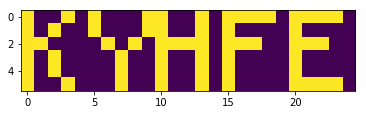

In [40]:
plt.imshow(imagekeeper, interpolation='nearest')
plt.show()

#### Day 9

In [41]:
class IntCode_v3:
    def __init__(self, intcode):
        self.intcode = intcode
        self.reset()
    
    def reset(self):
#         self.work_intcode = self.intcode[:]
        self.work_intcode = {idx:val for idx, val in enumerate(self.intcode)} 
        self.output = []
        self.mem = {}
        
    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as file:
            return cls([int(x) for x in file.read().split(',')])
    
    @classmethod
    def test_txt(cls, text, calc, **input_dict):
        test_intcode = cls([int(x) for x in text.split(',')])
        test_intcode.intcodeRead(calc, outmode = 0, **input_dict)
    
    def mode_manage(self, num, mode):
        if mode == 0:
            return self.work_intcode.get(num, 0)
        elif mode == 1:
            return num
        elif mode == 2:
            return self.work_intcode.get(self.mem['relbase'] + num, 0)
    
    def spec_mode_manage(self, num, mode):
        if mode == 0 or mode == 1:
            return num
        elif mode == 2:
            return self.mem['relbase'] + num
                
    def instr_manage(self, selfmem):      
        current_idx =  selfmem['current_idx']
        
        instr_str = str(self.work_intcode.get(current_idx, 0))
        params = {x:int(y) for x, y in enumerate(reversed(instr_str[:len(instr_str)-2]))}
        opcode = instr_str[len(instr_str)-2:]
        
        
#         print(instr_str, opcode)
        if int(opcode) == 1:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            self.work_intcode[output_loc] = param_a + param_b
            
            current_idx += 4
            
        elif int(opcode) == 2:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            self.work_intcode[output_loc] = param_a * param_b
            
            current_idx += 4

        elif int(opcode) == 3: 
            try:
                move_num = self.spec_mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))            
                self.work_intcode[move_num] = selfmem['inputs'][selfmem['input_idx']]
                selfmem['input_idx'] += 1
            
                current_idx += 2
            except IndexError:
                print('HALT COMMAND')
                selfmem['midhalt'] = 1
        
        elif int(opcode) == 4:
            val_output = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            self.output.append(val_output)
            
            current_idx += 2
        
        elif int(opcode) == 5:
            check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            if check != 0:
                current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 6:
            check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            if check == 0:
                current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 7:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            if param_a < param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
            
            current_idx += 4
        
        elif int(opcode) == 8:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            if param_a == param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
                
            current_idx += 4
        
        elif int(opcode) == 9:
            rel_adj = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            selfmem['relbase'] += rel_adj
                
            current_idx += 2
        
        return current_idx
       
    def intcodeRead(self, calc, outmode = 1, **input_dict):
        current_idx = 0
        
        if self.mem == {}:
            self.mem = input_dict
            self.mem['input_idx'] = 0
            self.mem['midhalt'] = None
            self.mem['current_idx'] = 0
            self.mem['relbase'] = 0
            
            if isinstance(self.mem.get('inputs',0), int):
                self.mem['inputs'] = [self.mem.get('inputs',0)]
        else:
            self.mem['inputs'] = input_dict['inputs']
            self.mem['midhalt'] = 0
#         print(self.output)
             
        if calc == 'nv':
            print(
                f'Calculating using NOUN/VERB method\n' 
                f'Noun: {nv.get("noun", 0)}\n' 
                f'Verb: {nv.get("verb", 0)}\n' 
                f"Note: If noun or verb used in inputs are > 99, noun and verb default to intcode's default values"
            )
            self.work_intcode[1] = self.mem.get('noun', x[1])
            self.work_intcode[2] = self.mem.get('verb', x[2])
            
        elif calc == 'input':
            print(
#                 f'Calculating using input method\n'
#                 f'Note: Default value if "val" variable not in parameters is 0'
            )
        
        while self.work_intcode.get(self.mem['current_idx'], 0) != 99 and self.mem['midhalt'] != 1:
#             print(self.mem['current_idx'])
            self.mem['current_idx'] = self.instr_manage(self.mem)

        reconstituted = [self.work_intcode.get(x, 0) for x in range(max(self.work_intcode)+1)]
        
        if outmode == 1:
            return reconstituted, self.output
        elif outmode == 'output_only':
            return self.output
        elif outmode == 'last_out':
            return self.output[-1]
        else:
            print(reconstituted, self.output, self.mem.get('inputs'))

In [42]:
boost_run = IntCode_v3.load('day09.txt')

In [43]:
boost_run.intcodeRead(calc = 'input', outmode = 0, inputs = 1)


[1102, 34463338, 34463338, 63, 1007, 63, 34463338, 63, 1005, 63, 53, 1102, 3, 1, 1000, 109, 988, 209, 12, 9, 1000, 209, 6, 209, 3, 203, 0, 1008, 1000, 1, 63, 1005, 63, 65, 1008, 1000, 2, 63, 1005, 63, 904, 1008, 1000, 0, 63, 1005, 63, 58, 4, 25, 104, 0, 99, 4, 0, 104, 0, 99, 4, 17, 104, 0, 99, 0, 2204990589, 1101, 0, 31, 1019, 1101, 25, 0, 1008, 1102, 35, 1, 1009, 1102, 422, 1, 1029, 1102, 1, 21, 1005, 1102, 1, 734, 1027, 1102, 29, 1, 1000, 1101, 32, 0, 1018, 1102, 28, 1, 1016, 1101, 0, 38, 1015, 1101, 0, 378, 1023, 1101, 30, 0, 1017, 1102, 1, 381, 1022, 1101, 0, 37, 1006, 1102, 1, 1, 1021, 1101, 0, 24, 1011, 1102, 1, 23, 1002, 1101, 0, 0, 1020, 1101, 0, 20, 1007, 1101, 427, 0, 1028, 1101, 26, 0, 1014, 1101, 27, 0, 1010, 1101, 0, 39, 1001, 1101, 34, 0, 1012, 1102, 1, 36, 1013, 1101, 0, 33, 1003, 1101, 804, 0, 1025, 1101, 737, 0, 1026, 1102, 1, 809, 1024, 1102, 1, 22, 1004, 109, 9, 1201, -7, 0, 63, 1008, 63, 20, 63, 1005, 63, 205, 1001, 64, 1, 64, 1106, 0, 207, 4, 187, 1002, 64, 2, 64,

In [44]:
boost_run.reset()
boost_run.intcodeRead(calc = 'input', outmode = 0, inputs = 2)


[1102, 34463338, 34463338, 63, 1007, 63, 34463338, 63, 1005, 63, 53, 1102, 3, 1, 1000, 109, 988, 209, 12, 9, 1000, 209, 6, 209, 3, 203, 0, 1008, 1000, 1, 63, 1005, 63, 65, 1008, 1000, 2, 63, 1005, 63, 904, 1008, 1000, 0, 63, 1005, 63, 58, 4, 25, 104, 0, 99, 4, 0, 104, 0, 99, 4, 17, 104, 0, 99, 1, 0, 1101, 0, 31, 1019, 1101, 25, 0, 1008, 1102, 35, 1, 1009, 1102, 422, 1, 1029, 1102, 1, 21, 1005, 1102, 1, 734, 1027, 1102, 29, 1, 1000, 1101, 32, 0, 1018, 1102, 28, 1, 1016, 1101, 0, 38, 1015, 1101, 0, 378, 1023, 1101, 30, 0, 1017, 1102, 1, 381, 1022, 1101, 0, 37, 1006, 1102, 1, 1, 1021, 1101, 0, 24, 1011, 1102, 1, 23, 1002, 1101, 0, 0, 1020, 1101, 0, 20, 1007, 1101, 427, 0, 1028, 1101, 26, 0, 1014, 1101, 27, 0, 1010, 1101, 0, 39, 1001, 1101, 34, 0, 1012, 1102, 1, 36, 1013, 1101, 0, 33, 1003, 1101, 804, 0, 1025, 1101, 737, 0, 1026, 1102, 1, 809, 1024, 1102, 1, 22, 1004, 109, 9, 1201, -7, 0, 63, 1008, 63, 20, 63, 1005, 63, 205, 1001, 64, 1, 64, 1106, 0, 207, 4, 187, 1002, 64, 2, 64, 109, 2, 

#### Day 10

##### Part 1

In [45]:
with open('day10.txt', 'r') as file:
#     print(file.readlines())
    asteroid_alias = {}
    refval = 0
    for y, row in enumerate(file.readlines()):
        for x, symbol in enumerate(row.strip()):
            if symbol == '#':
                asteroid_alias[refval] = (x,y)
                refval += 1

In [46]:
def calculate_distance(ast1, ast2):
    ast1 = np.array(ast1) 
    ast2 = np.array(ast2)
  
    distance = np.linalg.norm(np.array(ast1) - np.array(ast2))
    
    return distance
    
def calculate_angle(ast1, ast2):
    ast1 = np.array(ast1) 
    ast2 = np.array(ast2)
    # Convert coordinate sytem from top left (0,0), to asteroid B in relative position to asteroid A (0,0)
    astB_coord = (ast2 - ast1) * [1, -1] # converts y-coordinate

    #calculate degrees based on coordinate of 2nd point
    angle = np.degrees(np.arctan2(*astB_coord))
    
    return angle

In [47]:
# for each asteroid (alias), check all asteroids, keep a dict of angles:distance, and change when a lower distance is found for an angle
ast_output = {alias:{} for alias in asteroid_alias.keys()}

for x, origin in asteroid_alias.items():
    for y, target in asteroid_alias.items():
        sight_angle = calculate_angle(origin, target)
        distance = calculate_distance(origin, target)
        
        if (ast_output[x].get(sight_angle, None) == None) or (ast_output[x].get(sight_angle, None) > distance):
            ast_output[x][sight_angle] = distance

In [48]:
best_asteroid_station = sorted(ast_output, key = lambda x: len(ast_output[x].keys()), reverse=True)[0] #Sort by # of keys
los = len(ast_output[289].keys()) # Length of internal dictionary = Number of asteroids visible
print(f'Asteroid {best_asteroid_station}: {los} asteroids in Line of Sight (including itself)')

Asteroid 289: 284 asteroids in Line of Sight (including itself)


##### Part 1

In [49]:
ast289 = asteroid_alias[289]
relative_to_289 = [(alias, calculate_angle(ast289, coord), calculate_distance(ast289, coord))\
                   for alias, coord in asteroid_alias.items() if alias is not 289]

In [50]:
angledict = defaultdict(list)

for ast in relative_to_289:
    angle = ast[1]
    
    if angle < 0:
        angle = angle + 360

    angledict[angle].append((ast[0], ast[2]))
    angledict[angle] = sorted(angledict[angle], key=lambda x: x[1], reverse=False)
    
range_targets = sorted(angledict.keys())

In [51]:
range_idx = 0
destroyed = 0
target_list = deepcopy(angledict)

for val in range(len(relative_to_289)):
    true_idx = range_idx % len(range_targets)
    current_traj = range_targets[true_idx]
    
    try:
        shot = target_list[current_traj]
        print(f'Destroy count: {destroyed + 1} | Asteroid {shot[0]} destroyed, location {asteroid_alias[shot[0][0]]}, angle {current_traj}')
        shot.pop(0)
        
        destroyed += 1
        range_idx += 1
    
    except IndexError:
        print(f'No more asteroids in angle {current_traj}')
        range_idx += 1
        
        continue  

Destroy count: 1 | Asteroid (289, 0.0) destroyed, location (20, 19), angle 0.0
Destroy count: 2 | Asteroid (12, 19.026297590440446) destroyed, location (21, 0), angle 3.0127875041833403
Destroy count: 3 | Asteroid (56, 16.0312195418814) destroyed, location (21, 3), angle 3.576334374997351
Destroy count: 4 | Asteroid (69, 15.033296378372908) destroyed, location (21, 4), angle 3.8140748342903543
Destroy count: 5 | Asteroid (113, 12.041594578792296) destroyed, location (21, 7), angle 4.763641690726178
Destroy count: 6 | Asteroid (13, 19.1049731745428) destroyed, location (22, 0), angle 6.009005957494525
Destroy count: 7 | Asteroid (153, 9.055385138137417) destroyed, location (21, 10), angle 6.34019174590991
Destroy count: 8 | Asteroid (166, 8.06225774829855) destroyed, location (21, 11), angle 7.125016348901798
Destroy count: 9 | Asteroid (187, 7.0710678118654755) destroyed, location (21, 12), angle 8.13010235415598
Destroy count: 10 | Asteroid (99, 13.152946437965905) destroyed, location

In [52]:
# 200th destroyed asteroid: Alias 60, poistion (4,4)
# Answer is X * 100 + Y = 404

#### Day 11

##### Part 1

In [53]:
class paintBot():
    def __init__(self, int_filename, initposition = [0.,0.]):
        self.direction_ref  = {0: (np.array([0.,1.]), 'up'), 1: (np.array([1.,0.]), 'right'),\
                               2: (np.array([0.,-1.]), 'down'), 3: (np.array([-1.,0.]), 'left')}
        # Keys refer to current face, 0 (up) going in clockwise direction to 3 (left)
        # Values refer to movement method when facing that direction
        
        self.ICprocessor = IntCode_v3.load(int_filename)
        self.reset(initposition)
    
    def reset(self, initposition = [0., 0.]):
        self.ICprocessor.reset()
        
        self.position = np.array(initposition)
        self.face_idx = 0
        self.paintgrid = defaultdict(lambda: 0) # Should keep record of CURRENT canvas status
        self.inss = []
    
    def change_direction(self, dircode):
        idx_mod = np.where(dircode == 0, 1, -1)
        if dircode == 1:
            idx_mod = 1
        elif dircode == 0:
            idx_mod = -1
        
        self.face_idx = (self.face_idx + idx_mod) % 4
    
    def action_step(self):
        input_color = self.paintgrid[self.position.tobytes()]
        # 0 black, 1 white
        # Keys of self.paintgrid will keep memory of how many panels painted at least once
        
        print(f'Position: {self.position}\nFacing {self.direction_ref[self.face_idx][1]}\nCurrent color: {input_color}\n')
        self.inss.append(input_color)
        
        output = self.ICprocessor.intcodeRead(calc='input', outmode = 'output_only', inputs = self.inss)
        output_color = output[-2]
        output_dircode = output[-1]
        
        print(output[-2:])
        
        self.paintgrid[self.position.tobytes()] = output_color
        self.change_direction(output_dircode)
        self.position = self.position + self.direction_ref[self.face_idx][0]
        
       
    def run_paintBot(self, col_1 = 0):
        self.paintgrid[self.position.tobytes()] = col_1
        
        while self.ICprocessor.mem.get('midhalt', 1) == 1:
            self.action_step()    
    

In [54]:
pb = paintBot('day11.txt')

In [55]:
pb.reset()
pb.run_paintBot(col_1 = 0) # bot's starting position color is black (0)

Position: [0. 0.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-1.  0.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [-1.  1.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [0. 1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [0. 2.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-1.  2.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [-1.  3.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-2.  3.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [-2.  2.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [-1.  2.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [-1.  3.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [-2.  3.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [-2.  2.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [-1.  2.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [-1.  1.]



HALT COMMAND
[1, 0]
Position: [-3.  0.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [-3.  1.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [-2.  1.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [-2.  0.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [-3.  0.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [-3. -1.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [-2. -1.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [-2. -2.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [-3. -2.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [-3. -1.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [-2. -1.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [-2.  0.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-3.  0.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [-3.  1.]
Facing up
Current color: 0


HALT COMM

[0, 0]
Position: [7. 1.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [8. 1.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [8. 0.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [7. 0.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [7. 1.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [8. 1.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [8. 2.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [7. 2.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [7. 3.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [6. 3.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [6. 2.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [5. 2.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [5. 3.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [6. 3.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [6. 2.]
Facing down
Cu


HALT COMMAND
[1, 1]
Position: [4. 8.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [3. 8.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [3. 9.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [2. 9.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [2. 8.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [3. 8.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [3. 7.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [2. 7.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [2. 8.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [1. 8.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [1. 9.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [2. 9.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [ 2. 10.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 1. 10.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 1. 

[1, 1]
Position: [19.  4.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [19.  5.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [20.  5.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [20.  4.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [21.  4.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [21.  3.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [20.  3.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [20.  2.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [19.  2.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [19.  1.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [18.  1.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [18.  2.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [17.  2.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [17.  3.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Pos

HALT COMMAND
[1, 1]
Position: [22. 11.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [22. 12.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [21. 12.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [21. 11.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [22. 11.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [22. 12.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [23. 12.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [23. 13.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [22. 13.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [22. 12.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [21. 12.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [21. 11.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [20. 11.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [20. 12.]
Facing up
Current color: 0


HALT COMMAN

Position: [18. -4.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [19. -4.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [19. -5.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [18. -5.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [18. -6.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [19. -6.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [19. -5.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [18. -5.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [18. -4.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [17. -4.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [17. -5.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [18. -5.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [18. -4.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [19. -4.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: 

HALT COMMAND
[0, 0]
Position: [15. -5.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [16. -5.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [16. -6.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [17. -6.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [17. -5.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [16. -5.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [16. -4.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [15. -4.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [15. -3.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [14. -3.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [14. -4.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [15. -4.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [15. -3.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [14. -3.]
Facing left
Current color: 1


HALT COMMAN



HALT COMMAND
[1, 1]
Position: [30. 18.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [29. 18.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [29. 17.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [28. 17.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [28. 16.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 16.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [27. 15.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 15.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 14.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [27. 14.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [27. 15.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [28. 15.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [28. 16.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [27. 16.]
Facing left
Current color: 1


HALT COM

[0, 0]
Position: [23. 20.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [23. 19.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 19.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [24. 20.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 20.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 19.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [26. 19.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [26. 20.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 20.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 19.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [28. 19.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [28. 18.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [27. 18.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 19.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]


HALT COMMAND
[0, 1]
Position: [42. 17.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [42. 18.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [43. 18.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [43. 19.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [44. 19.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [44. 18.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [45. 18.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [45. 19.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [46. 19.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [46. 18.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [47. 18.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [47. 17.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [48. 17.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [48. 18.]
Facing up
Current color: 0


HALT CO

[1, 0]
Position: [48. 16.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [47. 16.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [47. 17.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [48. 17.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [48. 18.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. 18.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 17.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 17.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 16.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 16.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. 17.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [48. 17.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [48. 18.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 18.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Posit

HALT COMMAND
[0, 1]
Position: [37.  3.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [38.  3.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [38.  2.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [37.  2.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [37.  1.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [36.  1.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [36.  2.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [35.  2.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [35.  3.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [36.  3.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [36.  4.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [35.  4.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [35.  5.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [36.  5.]
Facing right
Current color: 1


HALT COMMAN

Position: [46. -9.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 46. -10.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 45. -10.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [45. -9.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [46. -9.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [46. -8.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [47. -8.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [47. -7.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [46. -7.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [46. -6.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [47. -6.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [47. -7.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [48. -7.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [48. -6.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position

HALT COMMAND
[1, 1]
Position: [49.  6.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [49.  7.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [48.  7.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [48.  6.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [49.  6.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [49.  7.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [48.  7.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [48.  8.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [49.  8.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [49.  7.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [48.  7.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [48.  8.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [47.  8.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [47.  9.]
Facing up
Current color: 0


HALT COMMAND




HALT COMMAND
[1, 1]
Position: [60. 23.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [60. 22.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [59. 22.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [59. 23.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [58. 23.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [58. 22.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [57. 22.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [57. 23.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [58. 23.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [58. 24.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [59. 24.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [59. 25.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [58. 25.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [58. 26.]
Facing up
Current color: 0


HALT COMMAND

[0, 1]
Position: [50. 22.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 22.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 21.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 21.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 20.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. 20.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [49. 19.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 19.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 20.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [51. 20.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 21.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 21.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 22.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [53. 22.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]



HALT COMMAND
[1, 1]
Position: [41. 31.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [40. 31.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 30.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [41. 30.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [41. 29.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [40. 29.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [40. 28.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [39. 28.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [39. 29.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [38. 29.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [38. 30.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [37. 30.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. 31.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [36. 31.]
Facing left
Current color: 0


HALT COMMAND

[0, 0]
Position: [38. 37.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [38. 38.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [37. 38.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. 39.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [38. 39.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [38. 40.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [39. 40.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [39. 39.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [38. 39.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [38. 38.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [39. 38.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [39. 39.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [40. 39.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 38.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Po

HALT COMMAND
[0, 1]
Position: [31. 28.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [31. 27.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [30. 27.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [30. 28.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [29. 28.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [29. 29.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [28. 29.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [28. 28.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 28.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 29.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 29.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 28.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 28.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 29.]
Facing up
Current color: 0


HALT COMMAND
[

Position: [17. 29.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [16. 29.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [16. 28.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [17. 28.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [17. 27.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [16. 27.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [16. 28.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [17. 28.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [17. 27.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [18. 27.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [18. 26.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [17. 26.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [17. 27.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [16. 27.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position:

HALT COMMAND
[0, 0]
Position: [28. 30.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [29. 30.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [29. 31.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [30. 31.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [30. 32.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [29. 32.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [29. 33.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [28. 33.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [28. 34.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [29. 34.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [29. 35.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [28. 35.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [28. 34.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 34.]
Facing left
Current color: 1


HALT COMMAND
[0



HALT COMMAND
[0, 0]
Position: [27. 47.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [28. 47.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [28. 48.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [29. 48.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [29. 49.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [30. 49.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [30. 50.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [31. 50.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [31. 49.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [30. 49.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [30. 50.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [31. 50.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [31. 49.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [32. 49.]
Facing right
Current color: 0


HALT COM

[0, 0]
Position: [32. 45.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [32. 46.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [33. 46.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [33. 47.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [32. 47.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [32. 46.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [31. 46.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [31. 47.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [32. 47.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [32. 48.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [33. 48.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [33. 49.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [34. 49.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [34. 48.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Posit


HALT COMMAND
[0, 1]
Position: [29. 54.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [29. 53.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [28. 53.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [28. 52.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [29. 52.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [29. 51.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [30. 51.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [30. 52.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [29. 52.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [29. 53.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [28. 53.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [28. 52.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [27. 52.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [27. 51.]
Facing down
Current color: 0


HALT CO

[0, 1]
Position: [43. 37.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [42. 37.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [42. 36.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [43. 36.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [43. 35.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [44. 35.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [44. 34.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [43. 34.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [43. 33.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [44. 33.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [44. 34.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [45. 34.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [45. 35.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [44. 35.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
P

HALT COMMAND
[1, 1]
Position: [50. 42.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 42.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. 43.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 43.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 44.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [49. 44.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 45.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [50. 45.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 46.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 46.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 45.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [52. 45.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 44.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [51. 44.]
Facing left
Current color: 1


HALT COMMA

Position: [49. 40.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. 41.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [48. 41.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [48. 42.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 42.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [49. 43.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [48. 43.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [48. 42.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [49. 42.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [49. 43.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [48. 43.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [48. 42.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [49. 42.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [49. 43.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [48

HALT COMMAND
[1, 0]
Position: [50. 53.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 54.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [49. 54.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. 55.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 55.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [50. 54.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 54.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 55.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 55.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 56.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 56.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [51. 57.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 57.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 56.]
Facing down
Current color: 1


HALT COMMAND



HALT COMMAND
[1, 1]
Position: [37. 60.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [37. 61.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [36. 61.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [36. 60.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [35. 60.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [35. 59.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [34. 59.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [34. 60.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. 60.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [35. 61.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [36. 61.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [36. 60.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. 60.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. 61.]
Facing up
Current color: 1


HALT COMM

[0, 0]
Position: [21. 47.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [22. 47.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [22. 46.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [21. 46.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [21. 45.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [22. 45.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [22. 44.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [21. 44.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [21. 43.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [20. 43.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [20. 42.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [21. 42.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [21. 43.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [20. 43.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]



HALT COMMAND
[1, 0]
Position: [20. 42.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [19. 42.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [19. 41.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [18. 41.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [18. 40.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [17. 40.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [17. 41.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [18. 41.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [18. 40.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [19. 40.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [19. 39.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [20. 39.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [20. 40.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [21. 40.]
Facing right
Current color: 1


HALT CO

[1, 1]
Position: [39. 30.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [39. 29.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 29.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 30.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [39. 30.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [39. 31.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 31.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [40. 32.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [41. 32.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [41. 31.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 31.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 32.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [41. 32.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [41. 33.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Posit

HALT COMMAND
[1, 1]
Position: [52. 11.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [52. 12.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [53. 12.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [53. 13.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [54. 13.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [54. 12.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [53. 12.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [53. 13.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [54. 13.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [54. 12.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [55. 12.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [55. 11.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [54. 11.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [54. 12.]
Facing up
Current color: 0


HALT COMMA

Position: [60. 12.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [59. 12.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [59. 11.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [60. 11.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [60. 10.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [59. 10.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [59.  9.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [58.  9.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [58. 10.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [59. 10.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [59. 11.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [60. 11.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [60. 12.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [61. 12.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: 

In [56]:
len(pb.paintgrid) #paintgrid keeps memory of current board state

2594

##### Part 2

In [57]:
pb.reset()
pb.run_paintBot(col_1 = 1)

Position: [0. 0.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [1. 0.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [ 1. -1.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 2. -1.]
Facing right
Current color: 0


HALT COMMAND
[0, 0]
Position: [2. 0.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [3. 0.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 3. -1.]
Facing down
Current color: 0


HALT COMMAND
[0, 0]
Position: [ 4. -1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [4. 0.]
Facing up
Current color: 0


HALT COMMAND
[0, 1]
Position: [5. 0.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [ 5. -1.]
Facing down
Current color: 0


HALT COMMAND
[0, 0]
Position: [ 6. -1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [6. 0.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [7. 0.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [ 7. -1.]
Fac

In [58]:
paint_x = []
paint_y = []


for tile in pb.paintgrid.keys():
    recovered = np.frombuffer(tile, count=-1)
    paint_x.append(recovered[0])
    paint_y.append(recovered[1])
    
(min(paint_x), max(paint_x), min(paint_y), max(paint_y)) # get canvas dimensions

(0.0, 42.0, -5.0, 0.0)

In [59]:
all_white_tiles = [np.frombuffer(tile, count=-1) + [0., 5.] for tile, col in pb.paintgrid.items() if col == 1]

In [60]:
canvas = np.zeros(shape=(6,43))
for fill in all_white_tiles:
    canvas[int(fill[1])][int(fill[0])] = 1

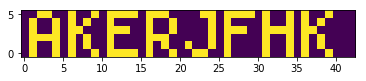

In [61]:
plt.imshow(canvas, interpolation='nearest', origin='lower')
plt.show()

#### Day 12

##### Part 1

In [62]:
def parse_poslines(list_):
    return np.array([[float(num) for num in re.sub(r'[^0-9,-]', '', x).split(',')] for x in list_])

In [63]:
def grav_update(arr1, arr2):
#     print((arr1, arr2, np.where(np.greater(arr1, arr2), -1., 1.)))
    return np.where(np.equal(arr1, arr2), 0., (np.where(np.greater(arr1, arr2), -1., 1.)))

In [64]:
def energy(pos, vel):
    en_list = []
    
    for x in range(len(pos)):
        pot = np.sum(np.abs(pos[x]))
        kin = np.sum(np.abs(vel[x]))
        en_list.append(pot*kin)
#         print(pos[x], pot, vel[x], kin)
    
#     print(en_list)
    return sum(en_list)

In [65]:
def update_step(pos, vel, it):
    
    for pos1, pos2 in itertools.combinations([idx for idx in range(len(pos))], 2):
        arr1 = pos[pos1]
        arr2 = pos[pos2]

        arr1_grav_change = grav_update(arr1, arr2)

        vel[pos1] = vel[pos1] + arr1_grav_change
        vel[pos2] = vel[pos2] - arr1_grav_change
    
    final = np.add(pos, vel)

#     print(f'Step {it+1}')
#     for print1, print2 in zip(final, vel):
#         print(f'{print1}\t\t{print2}')
    
    return final

In [66]:
with open('day12.txt', 'r') as file:
    positions = parse_poslines(file.readlines())

velocity = np.zeros(shape=(4,3))

In [67]:
position_copy = deepcopy(positions)
velocity_copy = deepcopy(velocity)

for it in range(1000):
    position_copy = update_step(position_copy, velocity_copy, it)

print(energy(position_copy, velocity_copy))

9958.0


##### Part 2

In [68]:
cycle_step = defaultdict(lambda: 0)

for idx in range(3):
    print(f'IDX {idx}')
    initial_1dim = np.array([x[idx] for x in positions])
    vel_1dim = np.zeros(shape = (4,))
    
    print(initial_1dim, vel_1dim)

    mem_pos_1dim = []
    mem_val_1dim = []

    while np.array_equal(initial_1dim, mem_pos_1dim) == False:
        if mem_pos_1dim == []:
            mem_pos_1dim = np.copy(initial_1dim)
            mem_val_1dim = np.copy(vel_1dim)
            mem_pos_1dim = update_step(mem_pos_1dim, mem_val_1dim, cycle_step[idx])
            cycle_step[idx] += 1
        else:
            mem_pos_1dim = update_step(mem_pos_1dim, mem_val_1dim, cycle_step[idx])
            cycle_step[idx] += 1

IDX 0
[ 7. -2. 12.  5.] [0. 0. 0. 0.]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


IDX 1
[10.  7.  5. -8.] [0. 0. 0. 0.]
IDX 2
[17.  0. 12.  6.] [0. 0. 0. 0.]


In [69]:
cycle_step

defaultdict(<function __main__.<lambda>()>, {0: 28481, 1: 231613, 2: 193051})

In [70]:
np.lcm([x+1 for x in cycle_step.values()])

AttributeError: module 'numpy' has no attribute 'lcm'